In [1]:
cd C:\EAP\KPI\Incidents

C:\EAP\KPI\Incidents


    In_Out_Type  In_Out  monitoring_run_date
0       OnGoing     100  2022_06_03_10_08_11
1       OnGoing      90  2022_06_03_10_09_16
2      OutGoing       2  2022_06_03_10_10_21
3       OnGoing      80  2022_06_03_10_11_27
4      Incoming      12  2022_06_03_10_12_32
..          ...     ...                  ...
363    OutGoing       3  2022_06_03_10_12_32
364    OutGoing       3  2022_06_03_10_12_32
365    OutGoing       3  2022_06_03_10_12_32
366    OutGoing       3  2022_06_03_10_12_32
367    OutGoing       3  2022_06_03_10_12_32

[368 rows x 3 columns]
Just to test only Ongoing Incident forecast


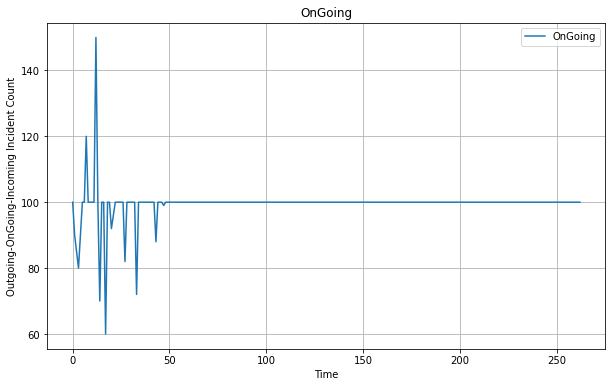

C:\Users\bondalas\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Analysis of Stock: OnGoing
6/6 [==============================] - 1s 171ms/step


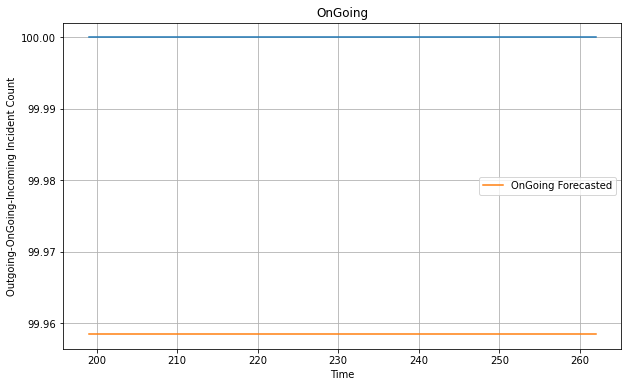

1/1 [==============================] - 0s 41ms/step
Future Forecast Out-On-In: [99.00627  98.98982  99.01517  99.0051   98.98439  99.00682  99.02225
 98.985275 98.97878  99.00453  98.95351  99.05234  99.04718  98.99768
 98.930984 98.626144 98.58393  98.271324 98.36033  98.415436 98.27743
 98.20972  98.02174  98.45953  98.06551  98.10544  98.52274  97.91736
 98.19087  98.08138  97.84553  97.43345  97.65381  97.05552  97.33328
 97.45049  97.16409  97.309814 97.205154 97.136536 96.792496 96.52558
 96.065765 96.90837  96.71731  96.15396  96.62119  96.272484 96.18448
 96.10652  96.08562  96.12645  95.49136  95.59212  95.367355 95.488754
 95.410706 95.24758  95.151375 94.86619  95.34783  95.17135  94.95868
 95.02615 ]
Mean Absolute Error Percentage,MEA of Out-In-Ongoing Incidents  OnGoing  :
2.9400628060102463


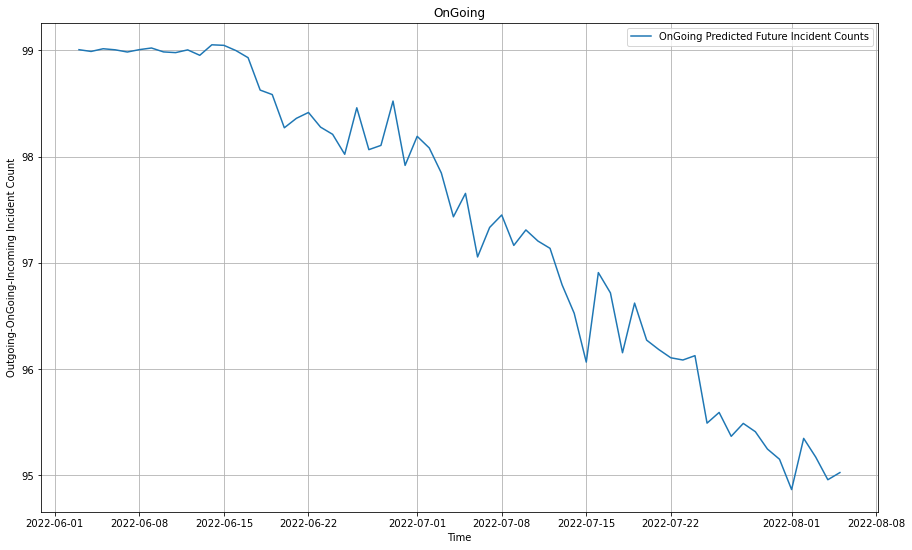

In [2]:


from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader as pdr
import datetime as dtt


keras = tf.keras


def plot_series(time, series,indexsymbol,label,  format="-", start=0, end=None   ):
    plt.title(indexsymbol)
    plot1, = plt.plot( time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Outgoing-OnGoing-Incoming Incident Count") 
    #if label:
    #plt.legend(fontsize=14)
    plt.legend([plot1],[label])
    plt.grid(True)



def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def process_in_out(AceDf,indexsymbol):  
 keras.backend.clear_session()
 AceDf = AceDf.dropna()
 time = AceDf.index.to_numpy()
 
 series = AceDf['In_Out'].to_numpy()
 
 plt.figure(figsize=(10, 6))
 plot_series(time, series, indexsymbol,indexsymbol)
 plt.show()
 
 time_dur=time.size

 window_size = 64
 split_time = int(time_dur/2)
 val_time = int(time_dur/4)
 val_limit_time = split_time + val_time
 time_train = time[:split_time]
 x_train = series[:split_time]
 time_valid = time[split_time:val_limit_time]
 x_valid = series[split_time:val_limit_time]
 time_test = time[val_limit_time:]
 x_test = series[val_limit_time:]

 last_window = series[-window_size:]
 last_time = time[-window_size:]

 


 train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
 valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

 model = keras.models.Sequential()
 model.add(keras.layers.InputLayer(input_shape=[None, 1]))
 for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
 model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

 optimizer = keras.optimizers.Adam(lr=3e-4)
 model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],run_eagerly=True)

 model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
 early_stopping = keras.callbacks.EarlyStopping(patience=50)

 history = model.fit(train_set,verbose=0, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
 print ("Analysis of Stock:",indexsymbol )
 print ("========================")
 print ("========================")
#history = model.fit(train_set,verbose = 0, epochs=500, callbacks=[lr_schedule])


 model = keras.models.load_model("my_checkpoint.h5")
#cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
 cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

 cnn_forecast = cnn_forecast[val_limit_time - window_size:-1, -1, 0]
 plt.figure(figsize=(10, 6))
 indexsymbol_legend_Act = indexsymbol + " Actual"
 indexsymbol_legend_Fore= indexsymbol + " Forecasted"
 plot_series(time_test, x_test, indexsymbol,indexsymbol_legend_Act)
 plot_series(time_test, cnn_forecast,indexsymbol, indexsymbol_legend_Fore)
 plt.show()
 #print ("Mean Absolute Error:MEA:")
 #print (keras.metrics.mean_absolute_error(x_test, cnn_forecast).numpy())
 for findex in range(window_size):
  future_forecast = model_forecast(model, last_window[:, np.newaxis], window_size)
  for i in range(window_size-1): 
   last_window[i]=last_window[i+1]
   last_window[window_size-1]=future_forecast[0][window_size-1][0]
#future_forecast = future_forecast[last_time - window_size:-1, -1, 0] 
 future_forecast = future_forecast.ravel()
 print ("Future Forecast Out-On-In:",future_forecast)
 plt.figure(figsize=(15, 9))
 #fut_time=np.arange(np.datetime64('2020-03-06'), np.datetime64('2020-05-09'))
 todatT=dtt.datetime.today().strftime('%Y-%m-%d')
 storeT=dtt.datetime.today()
 storeT = storeT + dtt.timedelta(days=64)
 
 fut_time=np.arange(np.datetime64(todatT), storeT.strftime('%Y-%m-%d'))
 #fut_time=np.arange(time[-1], np.datetime64('2020-05-04'))
 indexsymbol_legend_Fut = indexsymbol+" Predicted Future Incident Counts"
 plot_series(fut_time,future_forecast, indexsymbol,indexsymbol_legend_Fut)
 #tm1.sleep(3)
 MEA = keras.metrics.mean_absolute_error(x_test, cnn_forecast).numpy()
 percMEA = (MEA/future_forecast[0])*100
 print ("Mean Absolute Error Percentage,MEA of Out-In-Ongoing Incidents ",indexsymbol," :")
 print (percMEA)

#Main Program
 

CombDF=pd.read_excel("IN_OUT_TOTAL.xlsx", parse_dates=True,index_col=None)
print(CombDF)
OnGoingDF= CombDF[CombDF['In_Out_Type']=='OnGoing']
print("Just to test only Ongoing Incident forecast")
process_in_out(OnGoingDF,"OnGoing")


